<a href="https://colab.research.google.com/github/NattachaiWat/ml442/blob/master/Lab3_Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

TensorFlow 2.x selected.


# **Inferencing using tf.hub**

In [0]:
!pip install -q -U tensorflow_hub
import tensorflow_hub as hub
from tensorflow.keras import layers

In [0]:
classifier_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param ["https://tfhub.dev/google/tf2-preview/inception_v3/classification/4", "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"] {allow-input: true}

In [4]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

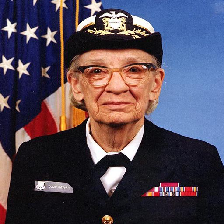

In [5]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [6]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [7]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [8]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [0]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

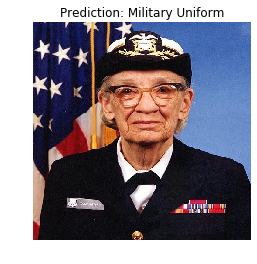

In [10]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

# **Simple transfer learning**

For this example you will use the TensorFlow flowers dataset:

In [19]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   cache_dir='./',
   untar=True)

228818944/228813984 [==============================] - 2s 0us/step


In [20]:
print(data_root)
!ls {data_root}

./datasets/flower_photos
daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


In [13]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [14]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [21]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [22]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['ice cream', 'daisy', 'rapeseed', 'boathouse', 'ant', 'daisy',
       'monastery', 'velvet', 'bee', 'daisy', 'daisy', 'picket fence',
       'pot', 'daisy', 'coral fungus', 'bee', 'goblet', 'daisy', 'bakery',
       'rapeseed', 'daisy', 'daisy', 'daisy', 'picket fence',
       'feather boa', 'greenhouse', 'bee', 'porcupine', 'daisy', 'daisy',
       'daisy', 'bee'], dtype='<U30')

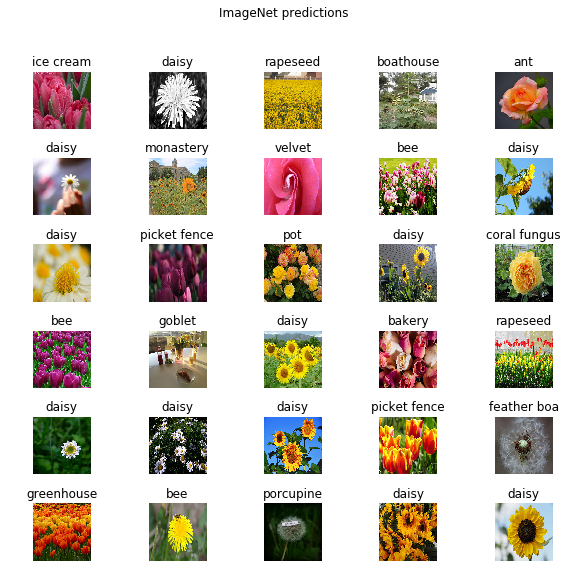

In [23]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [0]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [27]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [0]:
feature_extractor_layer.trainable = False

In [29]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
predictions = model(image_batch)

In [31]:
predictions.shape

TensorShape([32, 5])

In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [34]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Epoch 1/2
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


115/115 [==============================] - 37s 323ms/step - loss: 0.7230 - acc: 0.8750
Epoch 2/2
115/115 [==============================] - 31s 268ms/step - loss: 0.3485 - acc: 0.9062


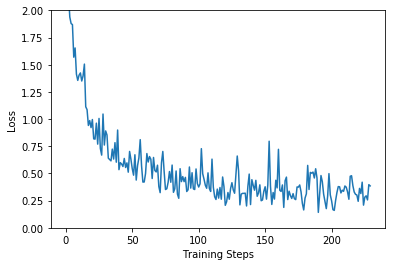

In [35]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

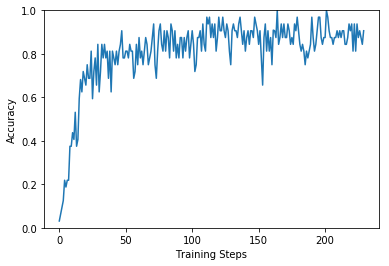

In [36]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [37]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [0]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [0]:
label_id = np.argmax(label_batch, axis=-1)

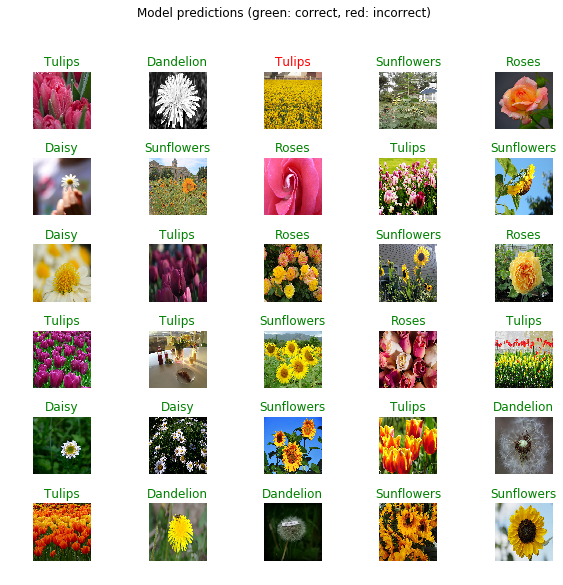

In [40]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

# **Export your model**

In [41]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.experimental.export_saved_model(model, export_path)

export_path

Instructions for updating:
Please use `model.save(..., save_format="tf")` or `tf.keras.models.save_model(..., save_format="tf")`.


Instructions for updating:
Please use `model.save(..., save_format="tf")` or `tf.keras.models.save_model(..., save_format="tf")`.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']


INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']


INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: /tmp/saved_models/1568436574/saved_model.pb


INFO:tensorflow:SavedModel written to: /tmp/saved_models/1568436574/saved_model.pb


'/tmp/saved_models/1568436574'

In [42]:
reloaded = tf.keras.experimental.load_from_saved_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

Instructions for updating:
The experimental save and load functions have been  deprecated. Please switch to `tf.keras.models.load_model`.


Instructions for updating:
The experimental save and load functions have been  deprecated. Please switch to `tf.keras.models.load_model`.


In [0]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [44]:
abs(reloaded_result_batch - result_batch).max()

0.0